In [96]:
%matplotlib inline
from refer import REFER
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import json
import math, copy, time, os, io, re, pickle, random
from pprint import pprint
from tqdm import tqdm
from collections import Counter, defaultdict
from matplotlib.patches import Polygon, Rectangle
import matplotlib.patches as patches

In [5]:
#%load_ext Cython
#import pyximport


The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


# Load Refer Dataset

In [248]:
data_root = '/projects/tir6/bisk/yingshac/MLVM/refer'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcocog'
splitBy = 'umd' ## mdetr also used the umd split!!!
refer = REFER(data_root, dataset, splitBy)

loading dataset refcocog into memory...
creating index...
index created.
DONE (t=6.51s)


# Stats about the Dataset

In [249]:
# print stats about the given dataset
print('dataset [%s_%s] contains: ' % (dataset, splitBy))
ref_ids = refer.getRefIds()
image_ids = refer.getImgIds()
print('%s expressions for %s refs in %s images.' % (len(refer.Sents), len(ref_ids), len(image_ids)))

print('\nAmong them:')
if dataset == 'refclef':
    if splitBy == 'unc':
        splits = ['train', 'val', 'testA', 'testB', 'testC']
    else:
        splits = ['train', 'val', 'test']
elif dataset == 'refcoco':
    splits = ['train', 'val', 'test']
elif dataset == 'refcoco+':
    splits = ['train', 'val', 'test']
elif dataset == 'refcocog':
    splits = ['train', 'val']  # we don't have test split for refcocog right now.
    
for split in splits:
    ref_ids = refer.getRefIds(split=split)
    print('%s refs are in split [%s].' % (len(ref_ids), split))
print(f"refer is of type REFER. refer.data has keys: {refer.data.keys()}")
print("provided split: {}".format(set([r['split'] for r in refer.data['refs']])))

dataset [refcocog_umd] contains: 
95010 expressions for 49822 refs in 25799 images.

Among them:
42226 refs are in split [train].
2573 refs are in split [val].
refer is of type REFER. refer.data has keys: dict_keys(['dataset', 'refs', 'images', 'annotations', 'categories'])
provided split: {'test', 'val', 'train'}


In [250]:
for k in refer.data:
    print(k, len(refer.data[k]))

dataset 8
refs 49822
images 25799
annotations 208960
categories 80


In [47]:
pprint(refer.data['images'][0])
pprint(refer.data['annotations'][0])

pprint(refer.data['refs'][0])

{'coco_url': 'http://mscoco.org/images/131074',
 'date_captured': '2013-11-21 01:03:06',
 'file_name': 'COCO_train2014_000000131074.jpg',
 'flickr_url': 'http://farm9.staticflickr.com/8308/7908210548_33e532d119_z.jpg',
 'height': 428,
 'id': 131074,
 'license': 1,
 'width': 640}
{'area': 48667.84089999999,
 'bbox': [16.31, 141.21, 421.29, 208.24],
 'category_id': 65,
 'id': 318235,
 'image_id': 131074,
 'iscrowd': 0,
 'segmentation': [[21.11,
                   239.09,
                   16.31,
                   274.6,
                   198.65,
                   349.45,
                   240.87,
                   336.98,
                   320.52,
                   293.79,
                   334.91,
                   248.69,
                   357.95,
                   273.64,
                   353.15,
                   289.0,
                   398.25,
                   267.88,
                   437.6,
                   251.57,
                   412.65,
                 

In [254]:
# 'sent' seems to have done punctuation-removel, white-space normalization and lowercase.
# but it also breaks something important, e.g. "9:00" --> "900"
# but it seems that 'sent' has done some useful substitution, e.g. "rt/r" --> "right", "2nd" --> "second", "w" --> "with"
# So I've decided to use 'raw' X --> No I changed my mind. I decided to use 'sent'
for k in np.random.permutation(list(range(len(refer.data['refs'])))):
    flag = False
    for s in refer.data['refs'][k]['sentences']:
        if not len(s['sent']) == len(s['raw']):
            pprint(s)
            flag = True
    if flag: break

{'raw': 'A red motorcycle.',
 'sent': 'a red motorcycle',
 'sent_id': 97746,
 'tokens': ['a', 'red', 'motorcycle']}


In [255]:
multi_polygons_ann_ids = [a['id'] for a in refer.data['annotations'] if len(a['segmentation'])>1]
print(len(multi_polygons_ann_ids))


24017


(640, 480) 480 640
[[[[119.33, 354.68], [106.68, 332.98], [94.02, 312.5], [92.21, 308.88], [124.75, 305.87], [141.02, 307.68], [159.1, 324.55], [160.91, 343.83], [143.43, 355.88], [130.18, 361.31], [136.2, 375.16], [137.41, 381.19], [118.13, 387.82], [115.72, 390.83], [150.06, 389.02], [162.72, 391.43], [169.35, 401.68], [160.91, 412.52], [153.08, 410.72], [153.08, 402.28], [118.73, 400.47], [115.72, 393.24], [113.31, 386.01], [107.28, 382.4], [104.87, 379.38], [103.66, 371.55], [107.88, 364.92], [115.72, 359.5], [119.33, 356.48], [119.93, 356.48]], [[35.57, 316.11], [27.74, 301.65], [22.92, 299.84], [21.11, 286.58], [13.28, 272.12], [3.64, 259.47], [1.22, 254.05], [1.83, 240.79], [9.06, 235.97], [23.52, 234.16], [33.16, 234.16], [47.62, 254.05], [55.46, 282.37], [55.46, 298.64], [53.65, 304.06], [53.65, 319.73], [47.62, 325.15], [45.82, 316.11], [41.0, 313.7], [33.76, 317.92], [33.76, 317.92]]]]
area = 6754.817349999998, mask area = 6965


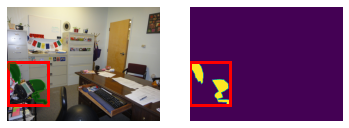

In [256]:
while True:
    k = random.choice(list(range(len(refer.data['refs']))))
    d = refer.data['refs'][k]
    if d['ann_id'] in multi_polygons_ann_ids: break

for im in refer.data['images']:
    if im['id'] == d['image_id']: 
        height = im['height']
        width = im['width']
        file_name = im['file_name']
for a in refer.data['annotations']:
    if a['id'] == d['ann_id']: 
        bbox = a['bbox']
        area = a['area']
        polygons = [[np.array(seg).reshape((len(seg)//2, 2)).tolist() for seg in a['segmentation']]]
fig = plt.figure()
ax1 = fig.add_subplot(121)
img = Image.open(os.path.join("/projects/tir6/bisk/yingshac/MLVM/MSCOCO/train2014", file_name)).convert('RGB')

print(img.size, height, width)
print(polygons)
#only one bbox? --- YES
ax1.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=3, edgecolor='r', facecolor='none'))
#the same box can have multiple polygons
for p in polygons[0]:
    ax1.add_patch(Polygon(p, fill=True, alpha=0.4, color='g'))
ax1.axis("off")
ax1.imshow(img)

# grayscale plot only showing the mask
img2 = Image.new('L', img.size, 0)  # (w, h)
for polys in polygons[0]:
    poly = [tuple(xy) for xy in polys]
    ImageDraw.Draw(img2).polygon(poly, outline=1, fill=1) 
mask = np.array(img2)
print(f"area = {area}, mask area = {mask.sum()}")
ax2 = fig.add_subplot(122)
ax2.axis("off")
ax2.imshow(mask)
ax2.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=3, edgecolor='r', facecolor='none'))


plt.show()


In [257]:
imgid2info = {}
for im in refer.data['images']:
    imgid2info[im['id']] = {
        'file_name': im['file_name'],
        'height': im['height'],
        'width': im['width'],
    }
print(len(imgid2info))

annid2info = {}
for a in refer.data['annotations']:
    try: annid2info[a['id']] = {
        'polygons': [[np.array(seg).reshape((len(seg)//2, 2)).tolist() for seg in a['segmentation']]],
        'bbox': a['bbox'],
    }
    except ValueError: pass # some annotations have a['segmentation'] = {'counts': [xxx, xxx, ...]}
print(len(annid2info))

25799
207785


In [260]:
split = 'test'
print(split, dataset, splitBy)
ret = []
for r in tqdm(refer.data['refs']):
    if not r['split'] == split: continue
    for s in r['sentences']:
        height = imgid2info[r['image_id']]['height']
        width = imgid2info[r['image_id']]['width']
        file_name = imgid2info[r['image_id']]['file_name']
        bbox = annid2info[r['ann_id']]['bbox']
        #area = round(annid2info[d['ann_id']]['area'], 4)
        polygons = annid2info[r['ann_id']]['polygons']
        caption = s['raw']
        ret.append({
            'image_id': r['image_id'],
            'height': height,
            'width': width,
            'file_name': file_name,
            'bbox': bbox,
            #'area': area,
            'polygons': polygons,
            'caption': caption,
            'id': s['sent_id'],
        })
print(len(ret), len(set([r['id'] for r in ret])))
save_filename = os.path.join("/projects/tir6/bisk/yingshac/MLVM/refseg", f"{dataset}_{splitBy}_{split}.json")
json.dump(ret, open(save_filename, "w"))
print(f"saved file to {save_filename}")


100%|██████████| 49822/49822 [00:00<00:00, 564709.83it/s]

test refcocog umd
9602 9602


saved file to /projects/tir6/bisk/yingshac/MLVM/refseg/refcocog_umd_test.json


(640, 480) 480 640
the big black and yellow truck


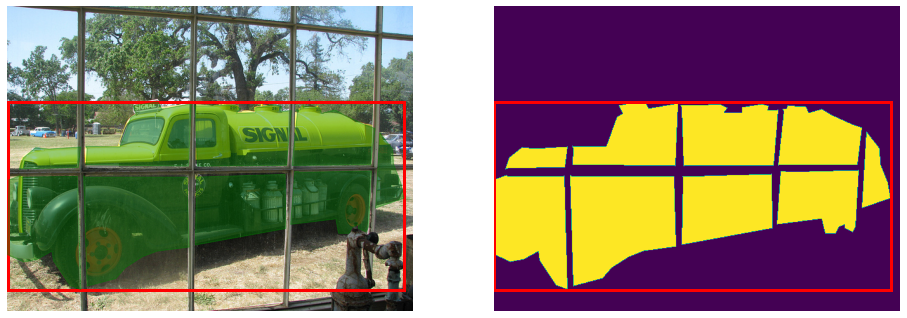

In [261]:
for k in np.random.permutation(list(range(len(ret)))):
    if len(ret[k]['polygons'][0]) > 1:
        #pprint(ret[k])
        break
#k=888
r = ret[k]
height = r['height']
width = r['width']
file_name = r['file_name']
bbox = r['bbox']
polygons = r['polygons']

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
img = Image.open(os.path.join("/projects/tir6/bisk/yingshac/MLVM/MSCOCO/train2014", file_name)).convert('RGB')

print(img.size, height, width)
#print(polygons)
print(r['caption'])
#only one bbox? --- YES
ax1.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=3, edgecolor='r', facecolor='none'))
#the same box can have multiple polygons
for p in polygons[0]:
    ax1.add_patch(Polygon(p, fill=True, alpha=0.4, color='g'))
ax1.axis("off")
ax1.imshow(img)

# grayscale plot only showing the mask
img2 = Image.new('L', img.size, 0)  # (w, h)
for polys in polygons[0]:
    poly = [tuple(xy) for xy in polys]
    ImageDraw.Draw(img2).polygon(poly, outline=1, fill=1) 
mask = np.array(img2)
ax2 = fig.add_subplot(122)
ax2.axis("off")
ax2.imshow(mask)
ax2.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=3, edgecolor='r', facecolor='none'))


plt.show()

In [262]:
ret[234]

{'image_id': 459951,
 'height': 426,
 'width': 640,
 'file_name': 'COCO_train2014_000000459951.jpg',
 'bbox': [151.27, 14.63, 146.02, 267.33],
 'polygons': [[[[206.17, 51.61],
    [207.68, 49.54],
    [208.81, 46.89],
    [206.74, 44.82],
    [205.6, 41.42],
    [205.6, 35.95],
    [203.15, 37.65],
    [202.21, 40.1],
    [200.32, 37.27],
    [203.72, 27.46],
    [208.43, 18.78],
    [218.24, 14.82],
    [227.11, 14.63],
    [239.0, 25.95],
    [241.83, 37.27],
    [240.32, 41.99],
    [235.79, 46.71],
    [232.2, 54.06],
    [231.64, 55.19],
    [239.37, 55.19],
    [249.37, 58.02],
    [254.09, 65.57],
    [257.29, 75.0],
    [271.44, 65.76],
    [281.63, 67.83],
    [292.01, 73.49],
    [296.16, 82.36],
    [297.29, 87.64],
    [295.59, 91.42],
    [295.59, 96.7],
    [292.95, 95.57],
    [285.22, 105.0],
    [281.44, 105.0],
    [277.67, 104.06],
    [273.14, 105.0],
    [273.52, 109.15],
    [267.67, 115.56],
    [259.94, 119.34],
    [256.92, 120.28],
    [252.01, 116.51],
    [2